# Load Necessary Libraries and Dataset

In [1]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
# for data
import pandas as pd
import numpy as np

# for visualization
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from wordcloud import WordCloud


# nltk used for NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Preprocessing (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay

# styling
plt.style.use('ggplot')

In [7]:
df = pd.read_csv("spam.csv", encoding='latin1')



In [8]:
# Suppose you want to drop columns 'Column1', 'Column2', and 'Column3'
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df.drop(columns=columns_to_drop, inplace=True)

Text(0.5, 1.0, 'Distribution of missing values')

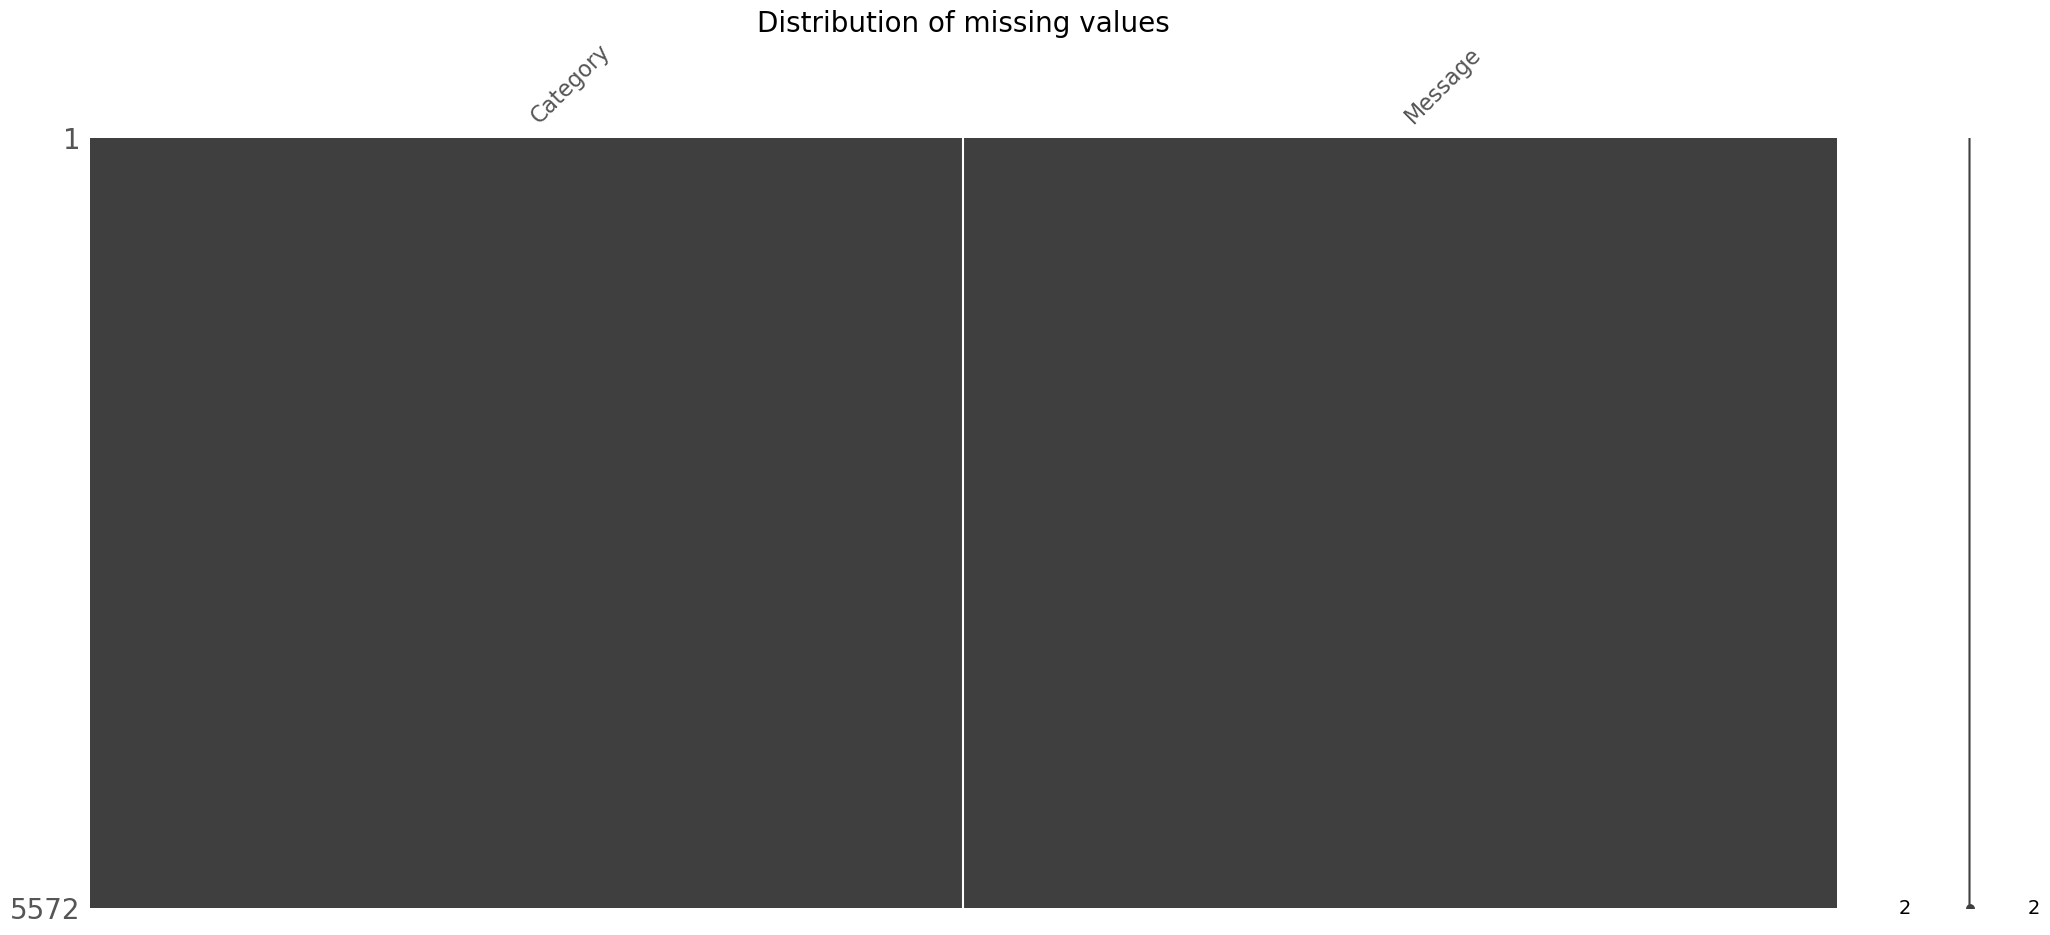

In [9]:
msno.matrix(df).set_title('Distribution of missing values', fontsize=20)

In [10]:
print(df.shape)
df.head(3)

(5572, 2)


Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...

# EDA on features (length added)


Two parts in 'EDA on each categories' section, each are:

(1) Explore Distribution of each categories

(2) Explore ham & spam message length distribution

# Distribution of each category  

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
category_ct = df['Category'].value_counts()

fig = px.pie(values=category_ct.values, 
             names=category_ct.index, 
             color_discrete_sequence=px.colors.sequential.OrRd,
             title= 'Pie Graph: spam or not')
fig.update_traces(hoverinfo='label+percent', textinfo='label+value+percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()

# Length distribution of spam & ham meesage

In [13]:
categories = pd.get_dummies(df["Category"])
spam_or_not = pd.concat([df, categories], axis=1)
spam_or_not.drop('Category',axis=1,inplace=True)

df["length"] = df["Message"].apply(len)

ham = df.loc[np.where(spam_or_not['ham'] == 1)].reset_index()
spam = df.loc[np.where(spam_or_not['ham'] == 0)].reset_index()

ham.drop('index',axis=1,inplace=True)
spam.drop('index',axis=1,inplace=True)

In [14]:
hist_data = [ham['length'],spam['length']]

group_labels = ['ham','spam']

colors = ['black', 'red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Length distribution of ham and spam messages',
                 template = 'simple_white')
fig.show()

#  Ham & Spam Message Analysis

Here, we'll explore unigrams of ham & spam messages, using (1)barplot and (2)wordcloud.

(1) define functions

(2) Term frequency by ham messages : 
         barplot and 
         word cloud

(3) Term frequency by spam messages: 
barplot and 
word cloud

# Define functions

In [15]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['Message'][i]
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
#     result = result.lower()                                              
#     result = nltk.word_tokenize(text)
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(stopwords, lst):
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
    return cleanwordlist

# function to get dataframe from cleanwordlist.
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to lemmatize words
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

Visualization functions below:

In [16]:
# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=100,
               colormap= colormap,
               max_font_size=140,
               min_font_size = 2,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Term frequency by ham message


In [17]:
ham.tail(3)

Category                                            Message  length
4822      ham  Pity, * was in mood for that. So...any other s...      57
4823      ham  The guy did some bitching but I acted like i'd...     125
4824      ham                         Rofl. Its true to its name      26

In [18]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mishr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
string = get_all_str(ham)
words = get_word(string)
removed = remove_stopword('1',words)
# show 10 words for example
print(removed[:10])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la']


In [20]:
freq_df = Freq_df(removed)
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, 
             title = 'Rank of Ham Terms',
             template = "simple_white"
              )

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

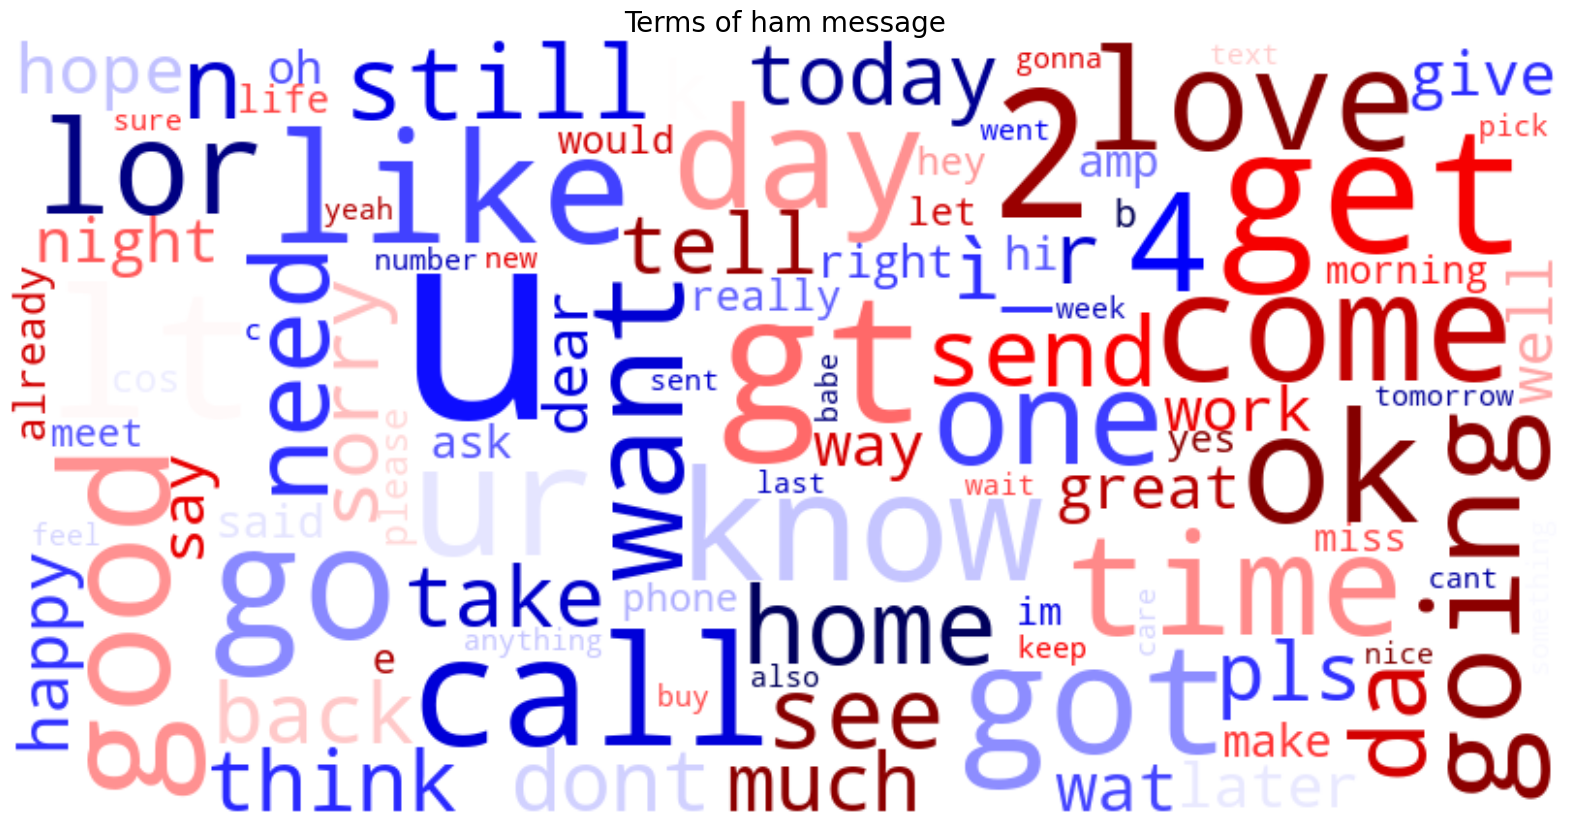

In [21]:
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

ham_wordcloud = Word_Cloud(data ,'white', 'seismic', 'Terms of ham message')

# Term frequency by spam message

In [22]:
string = get_all_str(spam)
words = get_word(string)
removed = remove_stopword('1',words)

In [23]:
# plt.figure(figsize=(20,5))
# sns.barplot(data = freq_df[:10],
#             x = 'Term', y = 'Frequency')
freq_df = Freq_df(removed)
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency',
             color_discrete_sequence=px.colors.sequential.PuRd, 
             title = 'Rank of Spam Terms', 
             template = "simple_white",
             color='Term')

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.show()

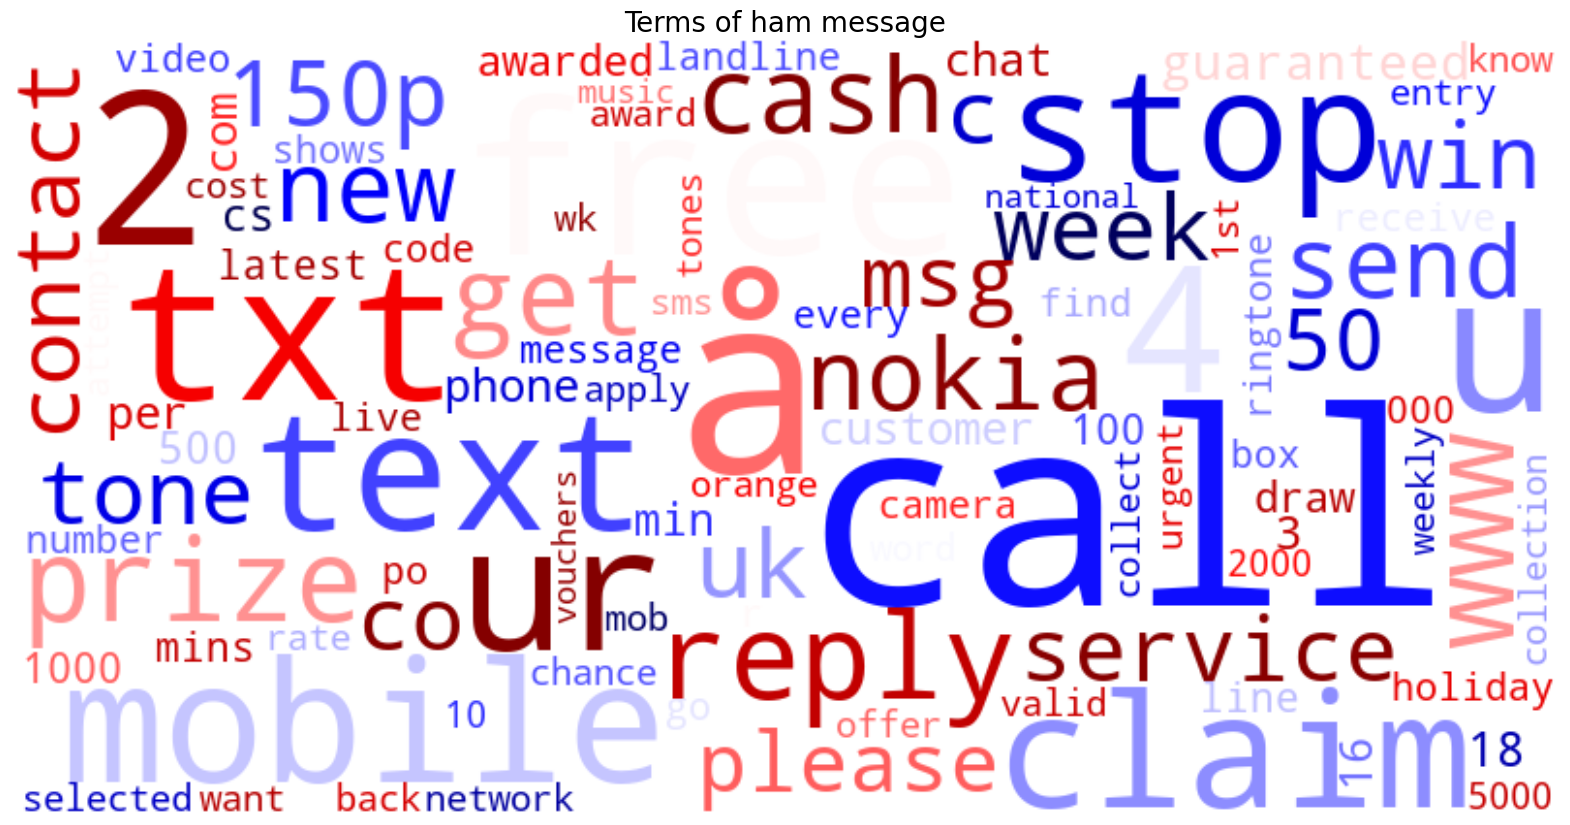

In [24]:
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

spam_wordcloud = Word_Cloud(data, 'white','seismic', 'Terms of ham message')

#  Text preprocessing for spam email detection

# define preprocessing function

In [25]:
def preprocess(sentence):
    words = get_word(sentence)
    words_ltz = lemmatization(words)
    removed = remove_stopword('1',words_ltz)
    return removed

In [26]:
df.replace('ham',1,inplace=True)
df.replace('spam',0,inplace=True)

In [27]:
df.head()

Category                                            Message  length
0         1  Go until jurong point, crazy.. Available only ...     111
1         1                      Ok lar... Joking wif u oni...      29
2         0  Free entry in 2 a wkly comp to win FA Cup fina...     155
3         1  U dun say so early hor... U c already then say...      49
4         1  Nah I don't think he goes to usf, he lives aro...      61

#  CountVectorizer

In [28]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mishr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mishr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
vector = CountVectorizer(analyzer = preprocess)
X = vector.fit(df['Message'])
X_transform = X.transform(df['Message'])


In [31]:
tfidf_transformer = TfidfTransformer().fit(X_transform)
X = tfidf_transformer.transform(X_transform)

# Train-test split

In [32]:
train_X, test_X, train_y, test_y = train_test_split(X, df['Category'], test_size=0.30, random_state = 8888) 

# Text Classification

Used 5 classification models in this notebook, each are:

RandomForestClassifier, LightGBMClassifier, XGBClassifier, SVC, CatBoostClassifier

# Define classifiers

In [33]:
rfc=RandomForestClassifier(random_state=8888)
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)
xgbr = xgb.XGBClassifier(objective='binary:hinge',random_state=8888)
svc = SVC(probability=True,random_state=8888)
catboost = CatBoostClassifier(random_state=8888, logging_level='Silent')

rfc.fit(train_X,train_y)
lgbm.fit(train_X, train_y)
xgbr.fit(train_X, train_y)
svc.fit(train_X, train_y)
catboost.fit(train_X,train_y,verbose=0)

classifiers = []
classifiers.append(svc)
classifiers.append(rfc)
classifiers.append(xgbr)
classifiers.append(lgbm)
classifiers.append(catboost)

model_name = ['SVC', 'Random Forest', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

# ML: Compare Evaluation Matrix

In [34]:
accuracy_list = []
auc_list=[]
recall_list = []
f1_list = []

for classifier in classifiers :
    y_pred=classifier.predict(test_X)
    y_pred_proba=classifier.predict_proba(test_X)[:,1]
    accuracy_list.append(accuracy_score(test_y,y_pred))
    auc_list.append(roc_auc_score(test_y, y_pred_proba))
    recall_list.append(recall_score(test_y, y_pred))
    f1_list.append(f1_score(test_y, y_pred))

In [35]:
def plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list, title):

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=model_name, y=np.round(accuracy_list,3), text=np.round(accuracy_list,3), marker_color='#97bad9'),    
        go.Bar(name='AUC',x=model_name, y=np.round(auc_list,3), text=np.round(auc_list,3), marker_color= '#bcd6ef'), 
        go.Bar(name='Recall',   x=model_name, y=np.round(recall_list,3), text=np.round(recall_list,3), marker_color='#ebcad9'),
        go.Bar(name='F1',       x=model_name, y=np.round(f1_list,3), text=np.round(f1_list,3), marker_color='#d5a6bd')
    ])
    
    fig.update_layout(template = 'simple_white', title = title)
    fig.update_layout(xaxis_title="Models", yaxis_title="Score", font = dict(size=17, family = 'Franklin Gothic'))
    fig.update_layout(yaxis_range=[0.7,1])
        
    fig.show()

In [36]:
plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list,
                 'Accuracy, AUC, Recall Score & F1 Score')

Here we can see that SVC got highest AUC score, and Random Forest the next.

Consider that models may exist overfitting, let's see mean values of cross validation score.

# ML: Cross Validation

In [ ]:
# set random_state
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=8888)
cv_accuracy_results = []
cv_auc_results = []
cv_recall_results = []
cv_f1_results = []

for classifier in classifiers:
    cv_accuracy_results.append(cross_val_score(classifier, train_X, y = train_y, scoring = "accuracy", cv = kfold))
    cv_auc_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'roc_auc', cv = kfold))
    cv_recall_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'recall', cv = kfold))
    cv_f1_results.append(cross_val_score(classifier, train_X, y= train_y, scoring = 'f1', cv = kfold))
    

cv_accuracy_means = []
cv_auc_means = []
cv_recall_means = []
cv_f1_means = []

for fold in range(5):
    cv_accuracy_means.append(cv_accuracy_results[fold].mean())
    cv_auc_means.append(cv_auc_results[fold].mean())
    cv_recall_means.append(cv_recall_results[fold].mean())
    cv_f1_means.append(cv_f1_results[fold].mean())

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means, 'Cross Validation (5 fold)')

It can be easily seen that Random Forest, LGBMClassifier and CatBoostClassifier got overall high score of each matrix.
Thus, i decided these three models to build an ensemble model using voting classifier.

#  Voting classifier Added (cv)

In [ ]:
votingC = VotingClassifier(estimators=[('light gbm', lgbm),('Random Forest', rfc),
                                       ('Cat boost',catboost)],voting='soft')

votingC = votingC.fit(train_X, train_y)

v_accuracy = cross_val_score(votingC, train_X, y = train_y, scoring = "accuracy", cv = kfold)
v_auc = cross_val_score(votingC, train_X, y = train_y, scoring = "roc_auc", cv = kfold)
v_recall = cross_val_score(votingC, train_X, y = train_y, scoring = "recall", cv = kfold)
v_f1 = cross_val_score(votingC, train_X, y = train_y, scoring = "f1", cv = kfold)

votingC_accuracy_mean = v_accuracy.mean()
votingC_auc_mean = v_auc.mean()
votingC_recall_mean = v_auc.mean()
votingC_f1_mean = v_auc.mean()

model_name.append('Voting Classifier')
cv_accuracy_means.append(votingC_accuracy_mean)
cv_auc_means.append(votingC_auc_mean)
cv_recall_means.append(votingC_recall_mean),
cv_f1_means.append(votingC_f1_mean)

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (5 fold), Voting Classifier Added')

# Voting Classifier: Model Evaluation

In [ ]:
voting_y_pred = votingC.predict(test_X)
voting_y_pred_proba=votingC.predict_proba(test_X)[:,1]

In [ ]:
voting_y_pred

In [ ]:
plt.style.use('default')
cm = confusion_matrix(test_y, voting_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['spam','ham'])
disp.plot(cmap='binary')

# LSTM Model

In [ ]:
X = df['Message']
y = df['Category']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state = 8888)    
max_len = max(max(train_X.apply(len).values),max(test_X.apply(len).values))

def fit_tokenizer(text, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token)
    tokenizer.fit_on_texts(text)
    return tokenizer

# for sequence, padding
def seq_padding(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)    
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen = maxlen, truncating=padding)
    return pad_trunc_sequences

tokenizer = fit_tokenizer(train_X, "<OOV>")

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

train_X = seq_padding(train_X,tokenizer, 'post', 'post',max_len)
test_X = seq_padding(test_X,tokenizer, 'post', 'post', max_len) 

def callback(MATRIX, PATIENCE):
    
    callbacks = [EarlyStopping(monitor=MATRIX, 
                                patience=PATIENCE, 
                                restore_best_weights=True), 
                  ModelCheckpoint('model',
                                  monitor=MATRIX,
                                  save_best_only=True, 
                                  save_weights_only=True)]
    return callbacks
        
def LSTM_model(vocab_size, embedding_dim, maxlen):
    
    model = Sequential()
    
    model.add(Embedding(vocab_size+1,embedding_dim,input_length = maxlen))
    model.add(Bidirectional(LSTM(64,kernel_regularizer=keras.regularizers.l2(0.001))))
    
    tf.keras.layers.GlobalAveragePooling1D()

    model.add(Dense(6, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics = ['Accuracy']) 
    
    return model

model = LSTM_model(VOCAB_SIZE, 100, max_len)

model.summary()

In [ ]:
history = model.fit(train_X, train_y, epochs = 8, batch_size = 8, callbacks = callback('Accuracy', 2))

test_prediction_label = (model.predict(test_X) >= 0.5).astype("int32")  
test_predict_proba = model.predict(test_X, verbose=0)

NN_accuracy = accuracy_score(test_y, test_prediction_label)
NN_AUC = roc_auc_score(test_y, test_prediction_label)
NN_recall = recall_score(test_y, test_prediction_label)
NN_f1 = f1_score(test_y, test_prediction_label)

print(NN_accuracy, NN_AUC, NN_recall, NN_f1)

In [ ]:
cv_accuracy_means.append(NN_accuracy)
cv_auc_means.append(NN_AUC)
cv_recall_means.append(NN_recall),
cv_f1_means.append(NN_f1)
model_name.append('NN')

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (5 fold)')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Convert text to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [ ]:
# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Create the Voting Classifier
voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')

In [ ]:
# Fit the Voting Classifier to the training data
voting_classifier.fit(X_train_counts, y_train_encoded)

In [ ]:
# Predict the labels for the test data
y_pred_encoded = voting_classifier.predict(X_test_counts)

In [ ]:
# Decode the predicted labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [ ]:
# Evaluate the performance of the Voting Classifier
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy*100)
print("AUC:", auc)
print("Recall:", recall)
print("F1 Score:", f1)

 This is the end of the notebook. We have implemented a Voting Classifier algorithm to build the final model. The Voting Classifier combines multiple individual classifiers  and makes predictions based on their combined outputs. It can often improve the overall performance and robustness of the model. Remember to preprocess the text data and encode the labels appropriately before fitting the Voting Classifier. Experiment with different classifiers and voting strategies to find the best combination for your task. Feel free to customize and extend this notebook further based on your specific requirements and datasets. Happy machine learning!
